In [ ]:
#Install necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

!pip install hydroeval
import hydroeval as he


#Define some function that creates data window for the model, and MAPE
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
  
def create_dataset_X(X, time_steps=1):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

def mean_absolute_percentage_error(y_t, y_p): 
    
    return np.mean(np.abs((y_t - y_p) / y_t)) * 100

##Change the directory to the folder containing long-format .csv files.
direct = "/content/drive/MyDrive/Final_sprwht_4"
##Set the name of crop here
crop = "Sprwht"
##Scroll to bottom and change the directory of output folder

lof = os.listdir(direct)

##Set up for evaluation metrics
performance_r2 = []
performance_mape = []
performance_nse = []
car_df = []

##Loop through each file, which will train model for each caruid
for f in lof:
  df = pd.read_csv(direct + "/" + f)

  car_df.append(int(f[7:-4]))
  timeline = []
  for i in range(0, len(df["Year"])):
    timeline.append(i)

  df["Weeks"] = timeline

  df.pop("Year")
  df.pop("Area")

  ##Prepare training and test data
  train_size = int(len(df) * 0.9)
  test_size = len(df) - train_size
  train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

  ##Have a copy of the dataframe from the .csv file
  full_data = df

  ##Column names to be scaled
  f_columns = ['SumPcpn', 'SumEGDD_C', 'SumHeatD','SumFrostD','AvgSI', 
             'AvgPrcnAWHC','NDVI']

  ##Scale x-data (predictor) and y-data (dependent)
  f_transformer = StandardScaler()
  yld_transformer = StandardScaler()

  f_transformer = f_transformer.fit(train[f_columns].to_numpy())
  yld_transformer = yld_transformer.fit(train[['Yield']])

  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
  train['Yield'] = yld_transformer.transform(train[['Yield']])

  test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
  test['Yield'] = yld_transformer.transform(test[['Yield']])

  ##Use previous 19 counts of data to train
  time_steps = 19

  # reshape to [samples, time_steps, n_features]

  ##Create training and test data window so that the model accepts it
  X_train, y_train = create_dataset(train, train.Yield, time_steps)
  X_test, y_test = create_dataset(test, test.Yield, time_steps)

  print(X_train.shape, y_train.shape)

  ##Make a folder to save a model
  !mkdir -p saved_model
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  )
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  ##Create an initial model
  history = model.fit(
      X_train, y_train,
      epochs=30,
      batch_size=32,
      validation_split=0.1,
      shuffle=False,
      verbose = False
  )

  model.save("saved_model" + "/" + f[:-4] + "/" + "model")

  MAX_EPOCHS = 50

  ##Function definition from Gil Paolo to repeatedly train the model
  def compile_and_fit(model, patience=5):
    # Checkpoint callback usage
    checkpoint_path = "saved_model" + "/" + f[:-4] + "/" + "training_1/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    monitor='val_accuracy',
                                                    verbose=1)
    
    #/# Currently using cp_callback instead of early_stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    # Changed from meansquarederror() to SparseCategoricalCrossentropy()
    # optimizer changed from tf.optimizer.Adam() to 'adam'
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer='adam',
                  metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,
                        batch_size=32, validation_split=0.1,
                        callbacks=[cp_callback])
    return history

  ##Train the model 20 times in 50 epochs
  for i in range(20):
    
    new_model = tf.keras.models.load_model("saved_model" + "/" + f[:-4] + "/" + "model")
    history = compile_and_fit(new_model)

    new_model.save("saved_model" + "/" + f[:-4] + "/" + "model")

  ##Now get the full data (from 1987 to 2020) so that it can predict yield from final model
  full_data.loc[:, f_columns] = f_transformer.transform(full_data[f_columns].to_numpy())
  #full_data['Yield'] = yld_transformer.transform(full_data[['Yield']])
  X_full_data = create_dataset_X(full_data, time_steps)

  df_pred = new_model.predict(X_full_data)
  #tf.keras.backend.clear_session()
  df_pred_inv = yld_transformer.inverse_transform(df_pred)

  yld_predict = []

  ##Get the predicted values into an array
  for i in (df_pred_inv):
    yld_predict.append(i[0])

  ##Get an actual yield data and put it in an array
  ##First year gets no prediction due to time step
  ##Example: If there are data from 1987 to 2020, only 1988 to 2020 will get prediction
  df = pd.read_csv(direct + "/" + f)
  yld_data = df["Yield"][19:]

  ##Get r-squared, MAPE, and MEI of the prediction
  correlation_matrix = np.corrcoef(yld_data.to_numpy(), yld_predict)
  correlation_xy = correlation_matrix[0,1]
  r2 = correlation_xy**2

  #r2 = r2_score(yld_data, yld_predict)
  mape = mean_absolute_percentage_error(yld_data, yld_predict)
  nse = he.evaluator(he.nse, yld_predict, yld_data)

  performance_r2.append(r2)
  performance_mape.append(mape)
  performance_nse.append(nse[0])

  df = df[19:]
  ##Append predicted yields into original df without first 19 rows
  df["Predict"] = yld_predict

  ##Create an output folder named [cropname]_predict, change directory here
  df.to_csv("/content/drive/MyDrive/" + crop + "_predict/" + f, index=False)

performance_df = pd.DataFrame(data={"CARUID": car_df, "R_squared": performance_r2,
                   "MAPE": performance_mape, "MEI": performance_nse})

##Also change directory here
performance_df.to_csv("/content/drive/MyDrive/" + crop + "_predict/" + crop + "_performance.csv", index=False)

(562, 19, 9) (562,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 81ms/step - loss: 0.5007 - mean_squared_error: 0.5007 - val_loss: 0.3517 - val_mean_squared_error: 0.3517

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 33ms/step - loss: 0.5332 - mean_squared_error: 0.5332 - val_loss: 0.2926 - val_mean_squared_error: 0.2926

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 33ms/step - loss: 0.4997 - mean_squared_error: 0.4997 - val_loss: 0.2968 - val_mean_squared_error: 0.2968

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.4407 - mean_squared_error: 0.4407 - val_loss: 0.3371 - val_mean_squared_error: 0.3371

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 81ms/step - loss: 0.1684 - mean_squared_error: 0.1684 - val_loss: 0.2890 - val_mean_squared_error: 0.2890

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 34ms/step - loss: 0.1051 - mean_squared_error: 0.1051 - val_loss: 0.0905 - val_mean_squared_error: 0.0905

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0864 - mean_squared_error: 0.0864 - val_loss: 0.0623 - val_mean_squared_error: 0.0623

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 0.0673 - val_mean_squared_error: 0.0673

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 80ms/step - loss: 0.1026 - mean_squared_error: 0.1026 - val_loss: 0.1288 - val_mean_squared_error: 0.1288

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0815 - mean_squared_error: 0.0815 - val_loss: 0.0451 - val_mean_squared_error: 0.0451

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0730 - mean_squared_error: 0.0730 - val_loss: 0.1185 - val_mean_squared_error: 0.1185

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0674 - mean_squared_error: 0.0674 - val_loss: 0.0387 - val_mean_squared_error: 0.0387

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 81ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - val_loss: 0.0358 - val_mean_squared_error: 0.0358

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0996 - val_mean_squared_error: 0.0996

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0422 - val_mean_squared_error: 0.0422

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0734 - val_mean_squared_error: 0.0734

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 34ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 84ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - val_loss: 0.0504 - val_mean_squared_error: 0.0504

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 0.0366 - val_mean_squared_error: 0.0366

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0609 - val_mean_squared_error: 0.0609

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0362 - val_mean_squared_error: 0.0362

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 33ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 82ms/step - loss: 0.0737 - mean_squared_error: 0.0737 - val_loss: 0.0877 - val_mean_squared_error: 0.0877

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 0.0502 - val_mean_squared_error: 0.0502

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0541 - val_mean_squared_error: 0.0541

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0418 - val_mean_squared_error: 0.0418

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 34ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 111ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.0467 - val_mean_squared_error: 0.0467

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0534 - val_mean_squared_error: 0.0534

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0347 - val_mean_squared_error: 0.0347

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0381 - val_mean_squared_error: 0.0381

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 34ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 85ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0710 - val_mean_squared_error: 0.0710

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0776 - val_mean_squared_error: 0.0776

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0455 - val_mean_squared_error: 0.0455

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0563 - val_mean_squared_error: 0.0563

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 82ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.1486 - val_mean_squared_error: 0.1486

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - val_loss: 0.0500 - val_mean_squared_error: 0.0500

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0342 - mean_squared_error: 0.0342 - val_loss: 0.0876 - val_mean_squared_error: 0.0876

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0551 - val_mean_squared_error: 0.0551

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 84ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0792 - val_mean_squared_error: 0.0792

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0297 - val_mean_squared_error: 0.0297

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0570 - val_mean_squared_error: 0.0570

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0447 - val_mean_squared_error: 0.0447

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 85ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0494 - val_mean_squared_error: 0.0494

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0550 - val_mean_squared_error: 0.0550

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0531 - val_mean_squared_error: 0.0531

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0903 - val_mean_squared_error: 0.0903

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 108ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.1104 - val_mean_squared_error: 0.1104

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.0569 - val_mean_squared_error: 0.0569

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0673 - val_mean_squared_error: 0.0673

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0832 - val_mean_squared_error: 0.0832

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 82ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0760 - val_mean_squared_error: 0.0760

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0872 - val_mean_squared_error: 0.0872

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0494 - val_mean_squared_error: 0.0494

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0465 - val_mean_squared_error: 0.0465

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 85ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0275 - val_mean_squared_error: 0.0275

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0577 - val_mean_squared_error: 0.0577

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0383 - val_mean_squared_error: 0.0383

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0785 - val_mean_squared_error: 0.0785

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 85ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0333 - val_mean_squared_error: 0.0333

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0480 - val_mean_squared_error: 0.0480

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0976 - val_mean_squared_error: 0.0976

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0712 - val_mean_squared_error: 0.0712

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 83ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0978 - val_mean_squared_error: 0.0978

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0865 - val_mean_squared_error: 0.0865

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0739 - val_mean_squared_error: 0.0739

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0959 - val_mean_squared_error: 0.0959

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 84ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0291 - val_mean_squared_error: 0.0291

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.1063 - val_mean_squared_error: 0.1063

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.1048 - val_mean_squared_error: 0.1048

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0840 - val_mean_squared_error: 0.0840

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 85ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.1040 - val_mean_squared_error: 0.1040

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0818 - val_mean_squared_error: 0.0818

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0505 - val_mean_squared_error: 0.0505

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0552 - val_mean_squared_error: 0.0552

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 87ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0507 - val_mean_squared_error: 0.0507

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0617 - val_mean_squared_error: 0.0617

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0925 - val_mean_squared_error: 0.0925

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0602 - val_mean_squared_error: 0.0602

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


Epoch 1/50
16/16 [==============================] - 4s 84ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0633 - val_mean_squared_error: 0.0633

Epoch 00001: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0610 - val_mean_squared_error: 0.0610

Epoch 00002: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0818 - val_mean_squared_error: 0.0818

Epoch 00003: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0757 - val_mean_squared_error: 0.0757

Epoch 00004: saving model to saved_model/SPRWHT_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4850/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(391, 19, 9) (391,)


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 5s 218ms/step - loss: 0.6327 - mean_squared_error: 0.6327 - val_loss: 0.4297 - val_mean_squared_error: 0.4297

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 38ms/step - loss: 0.5877 - mean_squared_error: 0.5877 - val_loss: 0.6363 - val_mean_squared_error: 0.6363

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 37ms/step - loss: 0.5531 - mean_squared_error: 0.5531 - val_loss: 0.3204 - val_mean_squared_error: 0.3204

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 0.5332 - mean_squared_error: 0.5332 - val_loss: 0.3649 - val_mean_squared_error: 0.3649

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 37ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 110ms/step - loss: 0.2245 - mean_squared_error: 0.2245 - val_loss: 0.1938 - val_mean_squared_error: 0.1938

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 38ms/step - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1812 - val_mean_squared_error: 0.1812

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 37ms/step - loss: 0.1433 - mean_squared_error: 0.1433 - val_loss: 0.1598 - val_mean_squared_error: 0.1598

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 40ms/step - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.1657 - val_mean_squared_error: 0.1657

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 37ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 5s 111ms/step - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.0562 - val_mean_squared_error: 0.0562

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 38ms/step - loss: 0.1049 - mean_squared_error: 0.1049 - val_loss: 0.0421 - val_mean_squared_error: 0.0421

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 37ms/step - loss: 0.0903 - mean_squared_error: 0.0903 - val_loss: 0.0354 - val_mean_squared_error: 0.0354

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0872 - mean_squared_error: 0.0872 - val_loss: 0.0582 - val_mean_squared_error: 0.0582

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 37ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 111ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0379 - val_mean_squared_error: 0.0379

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - val_loss: 0.0665 - val_mean_squared_error: 0.0665

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - val_loss: 0.0354 - val_mean_squared_error: 0.0354

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0673 - mean_squared_error: 0.0673 - val_loss: 0.0285 - val_mean_squared_error: 0.0285

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 39ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 5s 113ms/step - loss: 0.0775 - mean_squared_error: 0.0775 - val_loss: 0.0938 - val_mean_squared_error: 0.0938

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 0.0627 - val_mean_squared_error: 0.0627

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0705 - val_mean_squared_error: 0.0705

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.1285 - val_mean_squared_error: 0.1285

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 38ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 109ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - val_loss: 0.2765 - val_mean_squared_error: 0.2765

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.1755 - val_mean_squared_error: 0.1755

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0622 - val_mean_squared_error: 0.0622

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - val_loss: 0.0491 - val_mean_squared_error: 0.0491

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 39ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 5s 114ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.1392 - val_mean_squared_error: 0.1392

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0750 - val_mean_squared_error: 0.0750

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0409 - val_mean_squared_error: 0.0409

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.1009 - val_mean_squared_error: 0.1009

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 38ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 111ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0722 - val_mean_squared_error: 0.0722

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.1205 - val_mean_squared_error: 0.1205

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.0846 - val_mean_squared_error: 0.0846

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0792 - val_mean_squared_error: 0.0792

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 38ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 110ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - val_loss: 0.0904 - val_mean_squared_error: 0.0904

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 37ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.0384 - val_mean_squared_error: 0.0384

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0452 - val_mean_squared_error: 0.0452

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0441 - val_mean_squared_error: 0.0441

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 40ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 109ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - val_loss: 0.0967 - val_mean_squared_error: 0.0967

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 37ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0424 - val_mean_squared_error: 0.0424

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0848 - val_mean_squared_error: 0.0848

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0421 - val_mean_squared_error: 0.0421

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 39ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 111ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0792 - val_mean_squared_error: 0.0792

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0892 - val_mean_squared_error: 0.0892

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.1445 - val_mean_squared_error: 0.1445

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0540 - val_mean_squared_error: 0.0540

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 37ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 111ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0589 - val_mean_squared_error: 0.0589

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0669 - val_mean_squared_error: 0.0669

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0563 - val_mean_squared_error: 0.0563

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0876 - val_mean_squared_error: 0.0876

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 40ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 109ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0894 - val_mean_squared_error: 0.0894

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0943 - val_mean_squared_error: 0.0943

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0786 - val_mean_squared_error: 0.0786

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.1450 - val_mean_squared_error: 0.1450

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 40ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 5s 117ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0896 - val_mean_squared_error: 0.0896

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.1442 - val_mean_squared_error: 0.1442

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0827 - val_mean_squared_error: 0.0827

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0755 - val_mean_squared_error: 0.0755

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 39ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 113ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0648 - val_mean_squared_error: 0.0648

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0939 - val_mean_squared_error: 0.0939

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0448 - val_mean_squared_error: 0.0448

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0873 - val_mean_squared_error: 0.0873

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 44ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 151ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.1028 - val_mean_squared_error: 0.1028

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0854 - val_mean_squared_error: 0.0854

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0878 - val_mean_squared_error: 0.0878

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.1004 - val_mean_squared_error: 0.1004

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 38ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 5s 115ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.1221 - val_mean_squared_error: 0.1221

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.1245 - val_mean_squared_error: 0.1245

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0856 - val_mean_squared_error: 0.0856

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0860 - val_mean_squared_error: 0.0860

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 40ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 112ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0916 - val_mean_squared_error: 0.0916

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.1024 - val_mean_squared_error: 0.1024

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.1059 - val_mean_squared_error: 0.1059

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.1095 - val_mean_squared_error: 0.1095

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 39ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 5s 113ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.1344 - val_mean_squared_error: 0.1344

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0796 - val_mean_squared_error: 0.0796

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.1026 - val_mean_squared_error: 0.1026

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0741 - val_mean_squared_error: 0.0741

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 42ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


Epoch 1/50
11/11 [==============================] - 4s 111ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.1128 - val_mean_squared_error: 0.1128

Epoch 00001: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.1228 - val_mean_squared_error: 0.1228

Epoch 00002: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.1053 - val_mean_squared_error: 0.1053

Epoch 00003: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.1263 - val_mean_squared_error: 0.1263

Epoch 00004: saving model to saved_model/SPRWHT_5901/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 39ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5901/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(545, 19, 9) (545,)


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.3137 - mean_squared_error: 0.3137 - val_loss: 0.3265 - val_mean_squared_error: 0.3265

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.2679 - mean_squared_error: 0.2679 - val_loss: 0.3198 - val_mean_squared_error: 0.3198

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.2790 - mean_squared_error: 0.2790 - val_loss: 0.3785 - val_mean_squared_error: 0.3785

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.2439 - mean_squared_error: 0.2439 - val_loss: 0.3396 - val_mean_squared_error: 0.3396

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 87ms/step - loss: 0.1179 - mean_squared_error: 0.1179 - val_loss: 0.3373 - val_mean_squared_error: 0.3373

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0871 - mean_squared_error: 0.0871 - val_loss: 0.1581 - val_mean_squared_error: 0.1581

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0714 - mean_squared_error: 0.0714 - val_loss: 0.0958 - val_mean_squared_error: 0.0958

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 0.2037 - val_mean_squared_error: 0.2037

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0757 - mean_squared_error: 0.0757 - val_loss: 0.1452 - val_mean_squared_error: 0.1452

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0900 - val_mean_squared_error: 0.0900

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0918 - val_mean_squared_error: 0.0918

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.1122 - val_mean_squared_error: 0.1122

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 85ms/step - loss: 0.0486 - mean_squared_error: 0.0486 - val_loss: 0.0990 - val_mean_squared_error: 0.0990

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0884 - val_mean_squared_error: 0.0884

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0963 - val_mean_squared_error: 0.0963

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0828 - val_mean_squared_error: 0.0828

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 89ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.1195 - val_mean_squared_error: 0.1195

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0659 - val_mean_squared_error: 0.0659

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.1188 - val_mean_squared_error: 0.1188

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.1367 - val_mean_squared_error: 0.1367

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 115ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.1179 - val_mean_squared_error: 0.1179

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0803 - val_mean_squared_error: 0.0803

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.1079 - val_mean_squared_error: 0.1079

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.1527 - val_mean_squared_error: 0.1527

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 89ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.1571 - val_mean_squared_error: 0.1571

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.1344 - val_mean_squared_error: 0.1344

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0960 - val_mean_squared_error: 0.0960

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.1283 - val_mean_squared_error: 0.1283

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 87ms/step - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.1219 - val_mean_squared_error: 0.1219

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0825 - val_mean_squared_error: 0.0825

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.1653 - val_mean_squared_error: 0.1653

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.1167 - val_mean_squared_error: 0.1167

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.1190 - val_mean_squared_error: 0.1190

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.1295 - val_mean_squared_error: 0.1295

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0880 - val_mean_squared_error: 0.0880

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.1930 - val_mean_squared_error: 0.1930

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 89ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.1504 - val_mean_squared_error: 0.1504

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.1215 - val_mean_squared_error: 0.1215

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.1777 - val_mean_squared_error: 0.1777

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.1463 - val_mean_squared_error: 0.1463

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.1386 - val_mean_squared_error: 0.1386

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.1336 - val_mean_squared_error: 0.1336

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0878 - val_mean_squared_error: 0.0878

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.1190 - val_mean_squared_error: 0.1190

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 89ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 0.0917 - val_mean_squared_error: 0.0917

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.1023 - val_mean_squared_error: 0.1023

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.1720 - val_mean_squared_error: 0.1720

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0822 - val_mean_squared_error: 0.0822

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 85ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.1177 - val_mean_squared_error: 0.1177

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.1167 - val_mean_squared_error: 0.1167

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.1222 - val_mean_squared_error: 0.1222

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.1656 - val_mean_squared_error: 0.1656

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 87ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.1106 - val_mean_squared_error: 0.1106

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.1505 - val_mean_squared_error: 0.1505

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.1565 - val_mean_squared_error: 0.1565

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.1084 - val_mean_squared_error: 0.1084

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 89ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.1073 - val_mean_squared_error: 0.1073

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.1225 - val_mean_squared_error: 0.1225

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.1218 - val_mean_squared_error: 0.1218

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.1118 - val_mean_squared_error: 0.1118

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.1710 - val_mean_squared_error: 0.1710

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.1259 - val_mean_squared_error: 0.1259

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.1551 - val_mean_squared_error: 0.1551

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.1237 - val_mean_squared_error: 0.1237

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 87ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.1394 - val_mean_squared_error: 0.1394

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.1457 - val_mean_squared_error: 0.1457

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0990 - val_mean_squared_error: 0.0990

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.1636 - val_mean_squared_error: 0.1636

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 91ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.1460 - val_mean_squared_error: 0.1460

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.1353 - val_mean_squared_error: 0.1353

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.1263 - val_mean_squared_error: 0.1263

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.1553 - val_mean_squared_error: 0.1553

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 90ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.1695 - val_mean_squared_error: 0.1695

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.1574 - val_mean_squared_error: 0.1574

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.1498 - val_mean_squared_error: 0.1498

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.1391 - val_mean_squared_error: 0.1391

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.1502 - val_mean_squared_error: 0.1502

Epoch 00001: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.1931 - val_mean_squared_error: 0.1931

Epoch 00002: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.1679 - val_mean_squared_error: 0.1679

Epoch 00003: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.1289 - val_mean_squared_error: 0.1289

Epoch 00004: saving model to saved_model/SPRWHT_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4860/model/assets


(545, 19, 9) (545,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 6s 87ms/step - loss: 0.3448 - mean_squared_error: 0.3448 - val_loss: 0.3327 - val_mean_squared_error: 0.3327

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.3291 - mean_squared_error: 0.3291 - val_loss: 0.4955 - val_mean_squared_error: 0.4955

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.3171 - mean_squared_error: 0.3171 - val_loss: 0.3962 - val_mean_squared_error: 0.3962

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.2736 - mean_squared_error: 0.2736 - val_loss: 0.2896 - val_mean_squared_error: 0.2896

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 89ms/step - loss: 0.1231 - mean_squared_error: 0.1231 - val_loss: 0.1094 - val_mean_squared_error: 0.1094

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0945 - mean_squared_error: 0.0945 - val_loss: 0.0815 - val_mean_squared_error: 0.0815

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0989 - val_mean_squared_error: 0.0989

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0826 - mean_squared_error: 0.0826 - val_loss: 0.0847 - val_mean_squared_error: 0.0847

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 86ms/step - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0967 - val_mean_squared_error: 0.0967

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0664 - mean_squared_error: 0.0664 - val_loss: 0.0906 - val_mean_squared_error: 0.0906

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0716 - mean_squared_error: 0.0716 - val_loss: 0.0914 - val_mean_squared_error: 0.0914

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0664 - mean_squared_error: 0.0664 - val_loss: 0.0752 - val_mean_squared_error: 0.0752

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 88ms/step - loss: 0.0700 - mean_squared_error: 0.0700 - val_loss: 0.1038 - val_mean_squared_error: 0.1038

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.1128 - val_mean_squared_error: 0.1128

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0537 - mean_squared_error: 0.0537 - val_loss: 0.0994 - val_mean_squared_error: 0.0994

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0543 - mean_squared_error: 0.0543 - val_loss: 0.1148 - val_mean_squared_error: 0.1148

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 90ms/step - loss: 0.0770 - mean_squared_error: 0.0770 - val_loss: 0.1624 - val_mean_squared_error: 0.1624

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0965 - val_mean_squared_error: 0.0965

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - val_loss: 0.1197 - val_mean_squared_error: 0.1197

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.0867 - val_mean_squared_error: 0.0867

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 0.1476 - val_mean_squared_error: 0.1476

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 0.1307 - val_mean_squared_error: 0.1307

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 0.0878 - val_mean_squared_error: 0.0878

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0797 - val_mean_squared_error: 0.0797

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 91ms/step - loss: 0.0586 - mean_squared_error: 0.0586 - val_loss: 0.2438 - val_mean_squared_error: 0.2438

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0646 - mean_squared_error: 0.0646 - val_loss: 0.1291 - val_mean_squared_error: 0.1291

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0777 - val_mean_squared_error: 0.0777

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0881 - val_mean_squared_error: 0.0881

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.1302 - val_mean_squared_error: 0.1302

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0390 - mean_squared_error: 0.0390 - val_loss: 0.0926 - val_mean_squared_error: 0.0926

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.1181 - val_mean_squared_error: 0.1181

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0891 - val_mean_squared_error: 0.0891

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 89ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0809 - val_mean_squared_error: 0.0809

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.1518 - val_mean_squared_error: 0.1518

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.1325 - val_mean_squared_error: 0.1325

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.1378 - val_mean_squared_error: 0.1378

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 90ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0991 - val_mean_squared_error: 0.0991

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.1359 - val_mean_squared_error: 0.1359

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.1746 - val_mean_squared_error: 0.1746

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.1347 - val_mean_squared_error: 0.1347

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 92ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.1317 - val_mean_squared_error: 0.1317

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.1153 - val_mean_squared_error: 0.1153

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.2327 - val_mean_squared_error: 0.2327

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.1826 - val_mean_squared_error: 0.1826

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 91ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.1717 - val_mean_squared_error: 0.1717

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.1172 - val_mean_squared_error: 0.1172

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.1851 - val_mean_squared_error: 0.1851

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.1611 - val_mean_squared_error: 0.1611

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 87ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.1491 - val_mean_squared_error: 0.1491

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.1699 - val_mean_squared_error: 0.1699

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.1765 - val_mean_squared_error: 0.1765

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.1360 - val_mean_squared_error: 0.1360

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 93ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.1710 - val_mean_squared_error: 0.1710

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.2105 - val_mean_squared_error: 0.2105

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.1557 - val_mean_squared_error: 0.1557

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.1959 - val_mean_squared_error: 0.1959

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 43ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 90ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.1686 - val_mean_squared_error: 0.1686

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.1309 - val_mean_squared_error: 0.1309

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.1431 - val_mean_squared_error: 0.1431

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.1947 - val_mean_squared_error: 0.1947

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 90ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.2002 - val_mean_squared_error: 0.2002

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.1414 - val_mean_squared_error: 0.1414

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.1818 - val_mean_squared_error: 0.1818

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.1760 - val_mean_squared_error: 0.1760

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 90ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.1687 - val_mean_squared_error: 0.1687

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.1558 - val_mean_squared_error: 0.1558

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.1701 - val_mean_squared_error: 0.1701

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.1446 - val_mean_squared_error: 0.1446

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 93ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.1860 - val_mean_squared_error: 0.1860

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.1994 - val_mean_squared_error: 0.1994

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 44ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.2156 - val_mean_squared_error: 0.2156

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.1457 - val_mean_squared_error: 0.1457

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 91ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.1478 - val_mean_squared_error: 0.1478

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.1424 - val_mean_squared_error: 0.1424

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.2523 - val_mean_squared_error: 0.2523

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.2279 - val_mean_squared_error: 0.2279

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 91ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.2268 - val_mean_squared_error: 0.2268

Epoch 00001: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.1565 - val_mean_squared_error: 0.1565

Epoch 00002: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.2096 - val_mean_squared_error: 0.2096

Epoch 00003: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.2035 - val_mean_squared_error: 0.2035

Epoch 00004: saving model to saved_model/SPRWHT_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4870/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(391, 19, 9) (391,)


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 6s 119ms/step - loss: 0.4702 - mean_squared_error: 0.4702 - val_loss: 0.0590 - val_mean_squared_error: 0.0590

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 42ms/step - loss: 0.3990 - mean_squared_error: 0.3990 - val_loss: 0.1425 - val_mean_squared_error: 0.1425

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 0.3842 - mean_squared_error: 0.3842 - val_loss: 0.0752 - val_mean_squared_error: 0.0752

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 42ms/step - loss: 0.3435 - mean_squared_error: 0.3435 - val_loss: 0.0391 - val_mean_squared_error: 0.0391

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 1s 46ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 113ms/step - loss: 0.1170 - mean_squared_error: 0.1170 - val_loss: 0.0064 - val_mean_squared_error: 0.0064

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 43ms/step - loss: 0.1006 - mean_squared_error: 0.1006 - val_loss: 0.0207 - val_mean_squared_error: 0.0207

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - val_loss: 0.0290 - val_mean_squared_error: 0.0290

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0073 - val_mean_squared_error: 0.0073

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 43ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 112ms/step - loss: 0.1115 - mean_squared_error: 0.1115 - val_loss: 0.0065 - val_mean_squared_error: 0.0065

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.0264 - val_mean_squared_error: 0.0264

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0612 - mean_squared_error: 0.0612 - val_loss: 0.0081 - val_mean_squared_error: 0.0081

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0086 - val_mean_squared_error: 0.0086

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 41ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 118ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 0.0364 - val_mean_squared_error: 0.0364

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - val_loss: 0.0236 - val_mean_squared_error: 0.0236

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0538 - val_mean_squared_error: 0.0538

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 46ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0054 - val_mean_squared_error: 0.0054

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 42ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 114ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0493 - val_mean_squared_error: 0.0493

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0082 - val_mean_squared_error: 0.0082

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0260 - val_mean_squared_error: 0.0260

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0064 - val_mean_squared_error: 0.0064

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 45ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 116ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0148 - val_mean_squared_error: 0.0148

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.0246 - val_mean_squared_error: 0.0246

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0086 - val_mean_squared_error: 0.0086

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 44ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.0156 - val_mean_squared_error: 0.0156

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 1s 49ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 5s 115ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0321 - val_mean_squared_error: 0.0321

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0126 - val_mean_squared_error: 0.0126

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0248 - val_mean_squared_error: 0.0248

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0117 - val_mean_squared_error: 0.0117

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 43ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 116ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - val_loss: 0.0727 - val_mean_squared_error: 0.0727

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0154 - val_mean_squared_error: 0.0154

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0404 - val_mean_squared_error: 0.0404

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 0.0160 - val_mean_squared_error: 0.0160

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 46ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 113ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0127 - val_mean_squared_error: 0.0127

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0171 - val_mean_squared_error: 0.0171

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0158 - val_mean_squared_error: 0.0158

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 46ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0246 - val_mean_squared_error: 0.0246

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 45ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 5s 116ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0959 - val_mean_squared_error: 0.0959

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 47ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0426 - val_mean_squared_error: 0.0426

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0186 - val_mean_squared_error: 0.0186

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0322 - val_mean_squared_error: 0.0322

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 44ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 124ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0351 - val_mean_squared_error: 0.0351

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0673 - val_mean_squared_error: 0.0673

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0205 - val_mean_squared_error: 0.0205

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0383 - val_mean_squared_error: 0.0383

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 42ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 117ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0317 - val_mean_squared_error: 0.0317

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.1557 - val_mean_squared_error: 0.1557

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0519 - val_mean_squared_error: 0.0519

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.1269 - val_mean_squared_error: 0.1269

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 1s 46ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 5s 124ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0356 - val_mean_squared_error: 0.0356

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0506 - val_mean_squared_error: 0.0506

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 1s 47ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0307 - val_mean_squared_error: 0.0307

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 44ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0301 - val_mean_squared_error: 0.0301

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 45ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 5s 118ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0296 - val_mean_squared_error: 0.0296

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.0364 - val_mean_squared_error: 0.0364

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 1s 45ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0829 - val_mean_squared_error: 0.0829

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0754 - val_mean_squared_error: 0.0754

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 1s 49ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 120ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.1416 - val_mean_squared_error: 0.1416

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 46ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0545 - val_mean_squared_error: 0.0545

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 44ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0761 - val_mean_squared_error: 0.0761

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 1s 47ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0320 - val_mean_squared_error: 0.0320

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 1s 47ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 120ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0356 - val_mean_squared_error: 0.0356

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 44ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0344 - val_mean_squared_error: 0.0344

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 1s 48ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0336 - val_mean_squared_error: 0.0336

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0304 - val_mean_squared_error: 0.0304

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 46ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 115ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0508 - val_mean_squared_error: 0.0508

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0390 - val_mean_squared_error: 0.0390

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0439 - val_mean_squared_error: 0.0439

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 1s 45ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0937 - val_mean_squared_error: 0.0937

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 0s 44ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 120ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0813 - val_mean_squared_error: 0.0813

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0335 - val_mean_squared_error: 0.0335

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 46ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0390 - val_mean_squared_error: 0.0390

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0655 - val_mean_squared_error: 0.0655

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 1s 47ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 116ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0398 - val_mean_squared_error: 0.0398

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 1s 46ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0441 - val_mean_squared_error: 0.0441

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 1s 46ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0330 - val_mean_squared_error: 0.0330

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0299 - val_mean_squared_error: 0.0299

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 1s 48ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


Epoch 1/50
11/11 [==============================] - 4s 118ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0547 - val_mean_squared_error: 0.0547

Epoch 00001: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 2/50
11/11 [==============================] - 0s 46ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0762 - val_mean_squared_error: 0.0762

Epoch 00002: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 3/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0379 - val_mean_squared_error: 0.0379

Epoch 00003: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 4/50
11/11 [==============================] - 1s 50ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0493 - val_mean_squared_error: 0.0493

Epoch 00004: saving model to saved_model/SPRWHT_5908/training_1/cp.ckpt
Epoch 5/50
11/11 [==============================] - 1s 47ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_5908/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(562, 19, 9) (562,)


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 99ms/step - loss: 0.4392 - mean_squared_error: 0.4392 - val_loss: 0.3512 - val_mean_squared_error: 0.3512

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 43ms/step - loss: 0.3833 - mean_squared_error: 0.3833 - val_loss: 0.3515 - val_mean_squared_error: 0.3515

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.3767 - mean_squared_error: 0.3767 - val_loss: 0.2545 - val_mean_squared_error: 0.2545

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.3359 - mean_squared_error: 0.3359 - val_loss: 0.2649 - val_mean_squared_error: 0.2649

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 91ms/step - loss: 0.1460 - mean_squared_error: 0.1460 - val_loss: 0.2125 - val_mean_squared_error: 0.2125

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0926 - mean_squared_error: 0.0926 - val_loss: 0.0863 - val_mean_squared_error: 0.0863

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0906 - mean_squared_error: 0.0906 - val_loss: 0.0732 - val_mean_squared_error: 0.0732

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 0.0948 - val_mean_squared_error: 0.0948

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 43ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 95ms/step - loss: 0.0771 - mean_squared_error: 0.0771 - val_loss: 0.0762 - val_mean_squared_error: 0.0762

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0646 - mean_squared_error: 0.0646 - val_loss: 0.0560 - val_mean_squared_error: 0.0560

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.1051 - val_mean_squared_error: 0.1051

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0617 - val_mean_squared_error: 0.0617

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 92ms/step - loss: 0.0792 - mean_squared_error: 0.0792 - val_loss: 0.0870 - val_mean_squared_error: 0.0870

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0624 - val_mean_squared_error: 0.0624

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0681 - val_mean_squared_error: 0.0681

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0413 - val_mean_squared_error: 0.0413

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 47ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 95ms/step - loss: 0.0605 - mean_squared_error: 0.0605 - val_loss: 0.0747 - val_mean_squared_error: 0.0747

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0703 - val_mean_squared_error: 0.0703

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 52ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.0410 - val_mean_squared_error: 0.0410

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0406 - val_mean_squared_error: 0.0406

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 92ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0623 - val_mean_squared_error: 0.0623

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0392 - val_mean_squared_error: 0.0392

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0405 - val_mean_squared_error: 0.0405

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0749 - val_mean_squared_error: 0.0749

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 44ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 97ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.1193 - val_mean_squared_error: 0.1193

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 44ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0464 - val_mean_squared_error: 0.0464

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0682 - val_mean_squared_error: 0.0682

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0914 - val_mean_squared_error: 0.0914

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 45ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 103ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0467 - val_mean_squared_error: 0.0467

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0844 - val_mean_squared_error: 0.0844

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0545 - val_mean_squared_error: 0.0545

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0411 - val_mean_squared_error: 0.0411

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 95ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.1540 - val_mean_squared_error: 0.1540

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0524 - val_mean_squared_error: 0.0524

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0724 - val_mean_squared_error: 0.0724

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0635 - val_mean_squared_error: 0.0635

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 131ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0667 - val_mean_squared_error: 0.0667

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0516 - val_mean_squared_error: 0.0516

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0827 - val_mean_squared_error: 0.0827

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0436 - val_mean_squared_error: 0.0436

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 45ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 161ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.1034 - val_mean_squared_error: 0.1034

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0604 - val_mean_squared_error: 0.0604

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0735 - val_mean_squared_error: 0.0735

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0776 - val_mean_squared_error: 0.0776

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 47ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 94ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.1311 - val_mean_squared_error: 0.1311

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0595 - val_mean_squared_error: 0.0595

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0780 - val_mean_squared_error: 0.0780

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0683 - val_mean_squared_error: 0.0683

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 98ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0707 - val_mean_squared_error: 0.0707

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0681 - val_mean_squared_error: 0.0681

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0573 - val_mean_squared_error: 0.0573

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0965 - val_mean_squared_error: 0.0965

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 48ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 100ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0913 - val_mean_squared_error: 0.0913

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0696 - val_mean_squared_error: 0.0696

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0943 - val_mean_squared_error: 0.0943

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0700 - val_mean_squared_error: 0.0700

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 50ms/ste

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 98ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0671 - val_mean_squared_error: 0.0671

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0625 - val_mean_squared_error: 0.0625

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0600 - val_mean_squared_error: 0.0600

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0491 - val_mean_squared_error: 0.0491

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 98ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0657 - val_mean_squared_error: 0.0657

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0375 - val_mean_squared_error: 0.0375

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0597 - val_mean_squared_error: 0.0597

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0737 - val_mean_squared_error: 0.0737

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 48ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 99ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0742 - val_mean_squared_error: 0.0742

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0687 - val_mean_squared_error: 0.0687

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0502 - val_mean_squared_error: 0.0502

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0558 - val_mean_squared_error: 0.0558

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 51ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 98ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0584 - val_mean_squared_error: 0.0584

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0514 - val_mean_squared_error: 0.0514

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0811 - val_mean_squared_error: 0.0811

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0603 - val_mean_squared_error: 0.0603

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 51ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 97ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0554 - val_mean_squared_error: 0.0554

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0610 - val_mean_squared_error: 0.0610

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0669 - val_mean_squared_error: 0.0669

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0682 - val_mean_squared_error: 0.0682

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 49ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 95ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0854 - val_mean_squared_error: 0.0854

Epoch 00001: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0705 - val_mean_squared_error: 0.0705

Epoch 00002: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0884 - val_mean_squared_error: 0.0884

Epoch 00003: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0673 - val_mean_squared_error: 0.0673

Epoch 00004: saving model to saved_model/SPRWHT_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 54ms/step

INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/SPRWHT_4841/model/assets


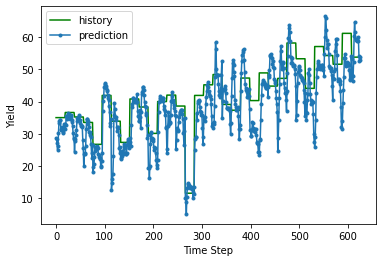

In [ ]:
pred = np.asarray(yld_predict, dtype=np.float32)

plt.plot(np.arange(0, len(yld_data.to_numpy())), yld_data.to_numpy().flatten(), 'g', label="history")
plt.plot(np.arange(0, len(pred)), pred.flatten(), marker='.', label="prediction")
plt.ylabel('Yield')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
performance_df = pd.DataFrame(data={"CARUID": car_df, "R_squared": performance_r2,
                   "MAPE": performance_mape, "MEI": performance_nse})

performance_df.to_csv("/content/drive/MyDrive/" + crop + "_predict/" + crop + "_performance.csv", index=False)

In [ ]:
correlation_matrix = np.corrcoef(yld_data.to_numpy(), yld_predict)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
he.evaluator(he.nse, yld_predict, yld_data.to_numpy())
r_squared

0.6688779349701113